# 1. From Posts(=submissions) to Networks

The goal of this section is to break-down a dataframe full of submissions, into a network. We will then visualize this network.
The overall steps are:
- Load the dataframe.
- Filter rows that contain interactions, i.e., commenting events.
- Generating an edgelist, then use it to generate a network object.
- Visualize network

# Install dependencies and import modules

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
%cd '/content/drive/MyDrive/Tutorial_2'

/content/drive/MyDrive/Tutorial_2


In [49]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import nltk

import datetime

# Read dataframe
We will use three files:  
(1) datascience-new-comment.csv: contains information on comments  
(2) datascience-new-submission.csv: contains information on submissions  
(3) datascience-user-data.csv: contains information on users

In [50]:
comments_df = pd.read_csv("./datascience-new-comment.csv", index_col=0)
comments_df.columns

Index(['author', 'body', 'body_html', 'created_utc', 'distinguished', 'edited',
       'id', 'is_submitter', 'link_id', 'parent_id', 'permalink', 'replies',
       'saved', 'score', 'stickied', 'submission', 'subreddit',
       'subreddit_id'],
      dtype='object')

In [ ]:
# 'created_utc' column contains Unix timestamp.
# This format tells us how many seconds have past since 1970-01-01 00:00:00
# Quite impressive (and actually practical), but not straightforward for us humans.
# Let's transforme those into YYYY-mm-dd hh:mm:ss format and save them in another column.

comments_df['created_utc_datetime'] = pd.to_datetime(comments_df['created_utc'], unit='s')
comments_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
0,No_Philosopher_5885,Learn a few shortcuts like adding cells above/...,"<div class=""md""><p>Learn a few shortcuts like ...",1.726106e+09,NaN,False,lmpaqfe,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,12,False,1fer01g,datascience,t5_2sptq,2024-09-12 01:50:50
1,sn0wdizzle,I thought this was an emacs troll post at first.,"<div class=""md""><p>I thought this was an emacs...",1.726115e+09,NaN,False,lmpvlkc,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,8,False,1fer01g,datascience,t5_2sptq,2024-09-12 04:23:55
2,decrementsf,"""If it hurts, train it"" is a good model for ge...","<div class=""md""><p>&quot;If it hurts, train it...",1.726108e+09,NaN,1726109473.0,lmpf6s6,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,15,False,1fer01g,datascience,t5_2sptq,2024-09-12 02:20:05
3,morganf74,"I like my ergo mouse from Logitech, it takes a...","<div class=""md""><p>I like my ergo mouse from L...",1.726145e+09,NaN,False,lmraavp,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,1,False,1fer01g,datascience,t5_2sptq,2024-09-12 12:47:05
4,After-Ad-5012,Touchscreen laptop. I learned python on a MacB...,"<div class=""md""><p>Touchscreen laptop. I learn...",1.726178e+09,NaN,False,lmu2bsu,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,1,False,1fer01g,datascience,t5_2sptq,2024-09-12 21:53:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,venkarafa,No I am not talking about ensemble models here...,"<div class=""md""><p>No I am not talking about e...",1.726138e+09,NaN,False,lmqv9mf,True,t3_1fehm3k,t1_lmqtujh,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,1,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 10:48:40
280,LaughTrackLife,This. It’s a reasonable statement for sending ...,"<div class=""md""><p>This. It’s a reasonable sta...",1.726106e+09,NaN,False,lmpb166,False,t3_1fehm3k,t1_lmopcig,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,0,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 01:52:47
281,manueldoedmotta,"Ok, so the average MAPE of all models don’t lo...","<div class=""md""><p>Ok, so the average MAPE of ...",1.726139e+09,NaN,False,lmqwvwr,False,t3_1fehm3k,t1_lmqv9mf,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,1,False,2,False,1fehm3k,datascience,t5_2sptq,2024-09-12 11:03:35
282,venkarafa,"""A suggestion is create a new metric like “Ove...","<div class=""md""><p>&quot;A suggestion is creat...",1.726141e+09,NaN,False,lmqztv2,True,t3_1fehm3k,t1_lmqwvwr,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,1,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 11:28:58


# Short-hand Pandas Filters


#### First, we filter comments that are under other comments, and are made at a specific date.  
In this case, 'parent_id' attribute starts with t1.

In [ ]:
## | is short-hand for OR ; & is short-hand for AND
today = datetime.datetime(2024, 9, 11)

comments_to_comments_df = comments_df[(comments_df.parent_id.str.startswith('t1')) & (comments_df.created_utc_datetime >= today)]
comments_to_comments_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
35,spigotface,Sometime Pandas will throw warnings even when ...,"<div class=""md""><p>Sometime Pandas will throw ...",1.726149e+09,NaN,False,lmrjhcr,False,t3_1feyx6h,t1_lmr9t2m,/r/datascience/comments/1feyx6h/favourite_piec...,4,False,136,False,1feyx6h,datascience,t5_2sptq,2024-09-12 13:45:24
36,Novel_Frosting_1977,I feel violated,"<div class=""md""><p>I feel violated</p>\n</div>",1.726148e+09,NaN,False,lmriidl,False,t3_1feyx6h,t1_lmr9t2m,/r/datascience/comments/1feyx6h/favourite_piec...,0,False,11,False,1feyx6h,datascience,t5_2sptq,2024-09-12 13:39:31
37,Kaiso25Gaming,"Damn, I thought I was being slick.","<div class=""md""><p>Damn, I thought I was being...",1.726156e+09,NaN,False,lms51dl,False,t3_1feyx6h,t1_lmr9t2m,/r/datascience/comments/1feyx6h/favourite_piec...,0,False,1,False,1feyx6h,datascience,t5_2sptq,2024-09-12 15:45:21
38,jonnyboyrebel,Quiet you!,"<div class=""md""><p>Quiet you!</p>\n</div>",1.726168e+09,NaN,False,lmt7k4x,False,t3_1feyx6h,t1_lmr9t2m,/r/datascience/comments/1feyx6h/favourite_piec...,0,False,1,False,1feyx6h,datascience,t5_2sptq,2024-09-12 19:08:22
39,BrockosaurusJ,"Sir, I get my depreciated functions from the T...","<div class=""md""><p>Sir, I get my depreciated f...",1.726170e+09,NaN,False,lmteqji,False,t3_1feyx6h,t1_lmr9t2m,/r/datascience/comments/1feyx6h/favourite_piec...,0,False,1,False,1feyx6h,datascience,t5_2sptq,2024-09-12 19:47:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,venkarafa,No I am not talking about ensemble models here...,"<div class=""md""><p>No I am not talking about e...",1.726138e+09,NaN,False,lmqv9mf,True,t3_1fehm3k,t1_lmqtujh,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,1,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 10:48:40
280,LaughTrackLife,This. It’s a reasonable statement for sending ...,"<div class=""md""><p>This. It’s a reasonable sta...",1.726106e+09,NaN,False,lmpb166,False,t3_1fehm3k,t1_lmopcig,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,0,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 01:52:47
281,manueldoedmotta,"Ok, so the average MAPE of all models don’t lo...","<div class=""md""><p>Ok, so the average MAPE of ...",1.726139e+09,NaN,False,lmqwvwr,False,t3_1fehm3k,t1_lmqv9mf,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,1,False,2,False,1fehm3k,datascience,t5_2sptq,2024-09-12 11:03:35
282,venkarafa,"""A suggestion is create a new metric like “Ove...","<div class=""md""><p>&quot;A suggestion is creat...",1.726141e+09,NaN,False,lmqztv2,True,t3_1fehm3k,t1_lmqwvwr,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,1,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 11:28:58


#### Next, we filter comments that are directly below submissions, and are made at a specific date (2023-08-22).
In this case, 'parent_id' attribute starts with t3.

In [ ]:
## | is short-hand for OR ; & is short-hand for AND
comments_to_submissions_df = comments_df[(comments_df.parent_id.str.startswith('t3') & (comments_df.created_utc_datetime >= today) & (comments_df.is_submitter == False))]
comments_to_submissions_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
0,No_Philosopher_5885,Learn a few shortcuts like adding cells above/...,"<div class=""md""><p>Learn a few shortcuts like ...",1.726106e+09,NaN,False,lmpaqfe,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,12,False,1fer01g,datascience,t5_2sptq,2024-09-12 01:50:50
1,sn0wdizzle,I thought this was an emacs troll post at first.,"<div class=""md""><p>I thought this was an emacs...",1.726115e+09,NaN,False,lmpvlkc,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,8,False,1fer01g,datascience,t5_2sptq,2024-09-12 04:23:55
2,decrementsf,"""If it hurts, train it"" is a good model for ge...","<div class=""md""><p>&quot;If it hurts, train it...",1.726108e+09,NaN,1726109473.0,lmpf6s6,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,15,False,1fer01g,datascience,t5_2sptq,2024-09-12 02:20:05
3,morganf74,"I like my ergo mouse from Logitech, it takes a...","<div class=""md""><p>I like my ergo mouse from L...",1.726145e+09,NaN,False,lmraavp,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,1,False,1fer01g,datascience,t5_2sptq,2024-09-12 12:47:05
4,After-Ad-5012,Touchscreen laptop. I learned python on a MacB...,"<div class=""md""><p>Touchscreen laptop. I learn...",1.726178e+09,NaN,False,lmu2bsu,False,t3_1fer01g,t3_1fer01g,/r/datascience/comments/1fer01g/wrist_pain_usi...,0,False,1,False,1fer01g,datascience,t5_2sptq,2024-09-12 21:53:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,NotMyRealName778,I think it's fine if you take a weighted avera...,"<div class=""md""><p>I think it&#39;s fine if yo...",1.726134e+09,NaN,False,lmqp2v2,False,t3_1fehm3k,t3_1fehm3k,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,0,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 09:43:28
273,manueldoedmotta,Are we talking about a forecasting ensemble mo...,"<div class=""md""><p>Are we talking about a fore...",1.726137e+09,NaN,False,lmqtujh,False,t3_1fehm3k,t3_1fehm3k,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,1,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 10:34:53
274,Science_competitor,The result is good,"<div class=""md""><p>The result is good</p>\n</div>",1.726159e+09,NaN,False,lmsd8pm,False,t3_1fehm3k,t3_1fehm3k,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,0,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-12 16:28:44
275,fil_geo,If results are all statistically significant y...,"<div class=""md""><p>If results are all statisti...",1.726088e+09,NaN,False,lmnx2ix,False,t3_1fehm3k,t3_1fehm3k,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,0,False,1,False,1fehm3k,datascience,t5_2sptq,2024-09-11 20:47:13


### We want to make edgelists.  
When comments are made below comments, they create a link in this case.  
Thus, 'source' is a comment under 'target' comment.

In [51]:
submission_df = pd.read_csv('./datascience-new-submission.csv', index_col=0)

In [52]:
# This dataframe shows who made 'source' comments, and the 'target' comments' ids

df1 = comments_to_comments_df[['author', 'parent_id', 'body']].copy()
df1['parent_id'] = df1['parent_id'].str.split('_').str[-1]
df1.columns = ['comment_to_comment_author', 'comment_id', 'comment_body']
df1

,comment_to_comment_author,comment_id,comment_body
35,spigotface,lmr9t2m,Sometime Pandas will throw warnings even when ...
36,Novel_Frosting_1977,lmr9t2m,I feel violated
37,Kaiso25Gaming,lmr9t2m,"Damn, I thought I was being slick."
38,jonnyboyrebel,lmr9t2m,Quiet you!
39,BrockosaurusJ,lmr9t2m,"Sir, I get my depreciated functions from the T..."
...,...,...,...
279,venkarafa,lmqtujh,No I am not talking about ensemble models here...
280,LaughTrackLife,lmopcig,This. It’s a reasonable statement for sending ...
281,manueldoedmotta,lmqv9mf,"Ok, so the average MAPE of all models don’t lo..."
282,venkarafa,lmqwvwr,"""A suggestion is create a new metric like “Ove..."


In [ ]:
# This dataframe shows who made 'target' comments, and the 'target' comments' ids

df2 = comments_to_comments_df[['author', 'id']]
df2.columns = ['comment_author', 'comment_id']
df2

,comment_author,comment_id
35,spigotface,lmrjhcr
36,Novel_Frosting_1977,lmriidl
37,Kaiso25Gaming,lms51dl
38,jonnyboyrebel,lmt7k4x
39,BrockosaurusJ,lmteqji
...,...,...
279,venkarafa,lmqv9mf
280,LaughTrackLife,lmpb166
281,manueldoedmotta,lmqwvwr
282,venkarafa,lmqztv2


In [ ]:
# merging two dataframe by inner join makes edgelists

df = df1.merge(df2, how='inner', on='comment_id')
df

,comment_to_comment_author,comment_id,comment_body,comment_author
0,JimmyTheCrossEyedDog,lmrjhcr,It's a very uninformative warning that usually...,spigotface
1,SpeedaRJ,lmrjhcr,"Another good one the ""weighty_only=True"" when ...",spigotface
2,hiimresting,lmrjhcr,That one happens when you try to alter data on...,spigotface
3,SaraSavvy24,lmrjhcr,Also Import ConfusionMatrixDisplay from sklear...,spigotface
4,numericalclerk,lmraayk,Aw lets not pretend highly experienced develop...,thicket
...,...,...,...,...
124,laughingwalls,lmq8dd4,Ive read that chat gpt2 can be run on a pc.,gomezalp
125,LaughTrackLife,lmopcig,This. It’s a reasonable statement for sending ...,JosephMamalia
126,manueldoedmotta,lmqv9mf,"Ok, so the average MAPE of all models don’t lo...",venkarafa
127,venkarafa,lmqwvwr,"""A suggestion is create a new metric like “Ove...",manueldoedmotta


In [ ]:
comments_network_df = df[['comment_to_comment_author', 'comment_author', 'comment_body']]
comments_network_df.columns = ['source', 'target', 'comment']
comments_network_df

,source,target,comment
0,JimmyTheCrossEyedDog,spigotface,It's a very uninformative warning that usually...
1,SpeedaRJ,spigotface,"Another good one the ""weighty_only=True"" when ..."
2,hiimresting,spigotface,That one happens when you try to alter data on...
3,SaraSavvy24,spigotface,Also Import ConfusionMatrixDisplay from sklear...
4,numericalclerk,thicket,Aw lets not pretend highly experienced develop...
...,...,...,...
124,laughingwalls,gomezalp,Ive read that chat gpt2 can be run on a pc.
125,LaughTrackLife,JosephMamalia,This. It’s a reasonable statement for sending ...
126,manueldoedmotta,venkarafa,"Ok, so the average MAPE of all models don’t lo..."
127,venkarafa,manueldoedmotta,"""A suggestion is create a new metric like “Ove..."


Also, when comments are made below submissions(=posts), they create a link in this case.  
Thus, 'source' is a comment under a 'target' post.

In [ ]:
df3 = comments_to_submissions_df[['author', 'body', 'link_id']].copy()
df3['link_id'] = df3['link_id'].str.split('_').str[-1]
df3.columns = ['comment_author', 'comment_body', 'submission_id']
df3

,comment_author,comment_body,submission_id
0,No_Philosopher_5885,Learn a few shortcuts like adding cells above/...,1fer01g
1,sn0wdizzle,I thought this was an emacs troll post at first.,1fer01g
2,decrementsf,"""If it hurts, train it"" is a good model for ge...",1fer01g
3,morganf74,"I like my ergo mouse from Logitech, it takes a...",1fer01g
4,After-Ad-5012,Touchscreen laptop. I learned python on a MacB...,1fer01g
...,...,...,...
272,NotMyRealName778,I think it's fine if you take a weighted avera...,1fehm3k
273,manueldoedmotta,Are we talking about a forecasting ensemble mo...,1fehm3k
274,Science_competitor,The result is good,1fehm3k
275,fil_geo,If results are all statistically significant y...,1fehm3k


In [ ]:
df4 = submission_df[['author', 'id']]
df4.columns = ['submission_author', 'submission_id']
df4

,submission_author,submission_id
0,renok_archnmy,1ffbxwd
1,JarryBohnson,1ffb9i0
2,JarryBohnson,1ffb67w
3,JarryBohnson,1ffb65l
4,jmhimara,1ff9usy
5,nobody_undefined,1feyx6h
6,gomezalp,1fetk7f
7,Waste_Necessary654,1fer01g
8,starktonny11,1feje1i
9,venkarafa,1fehm3k


In [ ]:
df = df3.merge(df4, how='inner', on='submission_id')
df

,comment_author,comment_body,submission_id,submission_author
0,No_Philosopher_5885,Learn a few shortcuts like adding cells above/...,1fer01g,Waste_Necessary654
1,sn0wdizzle,I thought this was an emacs troll post at first.,1fer01g,Waste_Necessary654
2,decrementsf,"""If it hurts, train it"" is a good model for ge...",1fer01g,Waste_Necessary654
3,morganf74,"I like my ergo mouse from Logitech, it takes a...",1fer01g,Waste_Necessary654
4,After-Ad-5012,Touchscreen laptop. I learned python on a MacB...,1fer01g,Waste_Necessary654
...,...,...,...,...
98,NotMyRealName778,I think it's fine if you take a weighted avera...,1fehm3k,venkarafa
99,manueldoedmotta,Are we talking about a forecasting ensemble mo...,1fehm3k,venkarafa
100,Science_competitor,The result is good,1fehm3k,venkarafa
101,fil_geo,If results are all statistically significant y...,1fehm3k,venkarafa


In [ ]:
sub_com_network_df = df[['comment_author', 'submission_author', 'comment_body']]
sub_com_network_df.columns = ['source', 'target', 'comment']
sub_com_network_df

,source,target,comment
0,No_Philosopher_5885,Waste_Necessary654,Learn a few shortcuts like adding cells above/...
1,sn0wdizzle,Waste_Necessary654,I thought this was an emacs troll post at first.
2,decrementsf,Waste_Necessary654,"""If it hurts, train it"" is a good model for ge..."
3,morganf74,Waste_Necessary654,"I like my ergo mouse from Logitech, it takes a..."
4,After-Ad-5012,Waste_Necessary654,Touchscreen laptop. I learned python on a MacB...
...,...,...,...
98,NotMyRealName778,venkarafa,I think it's fine if you take a weighted avera...
99,manueldoedmotta,venkarafa,Are we talking about a forecasting ensemble mo...
100,Science_competitor,venkarafa,The result is good
101,fil_geo,venkarafa,If results are all statistically significant y...


Now, we can concat both of edgelist dataframes (comment -> comment, comment -> submission) and finalize our edgelist dataframe.

In [ ]:
network_df = pd.concat([sub_com_network_df, comments_network_df], axis=0).reset_index(drop=True)
network_df

,source,target,comment
0,No_Philosopher_5885,Waste_Necessary654,Learn a few shortcuts like adding cells above/...
1,sn0wdizzle,Waste_Necessary654,I thought this was an emacs troll post at first.
2,decrementsf,Waste_Necessary654,"""If it hurts, train it"" is a good model for ge..."
3,morganf74,Waste_Necessary654,"I like my ergo mouse from Logitech, it takes a..."
4,After-Ad-5012,Waste_Necessary654,Touchscreen laptop. I learned python on a MacB...
...,...,...,...
227,laughingwalls,gomezalp,Ive read that chat gpt2 can be run on a pc.
228,LaughTrackLife,JosephMamalia,This. It’s a reasonable statement for sending ...
229,manueldoedmotta,venkarafa,"Ok, so the average MAPE of all models don’t lo..."
230,venkarafa,manueldoedmotta,"""A suggestion is create a new metric like “Ove..."


This is a newly defined class you can use out of the shelf

In [ ]:
import pandas as pd

class EdgelistGenerator:
    def __init__(self, comments_df, submissions_df):
        """
        Initialize the EdgelistGenerator with comments and submissions dataframes.

        :param comments_df: DataFrame containing comments data
        :param submissions_df: DataFrame containing submissions data
        """
        self.comments_df = comments_df
        self.submissions_df = submissions_df
        self.comments_to_comments_df = comments_df[comments_df.parent_id.str.startswith('t1')]
        self.comments_to_submissions_df = comments_df[comments_df.parent_id.str.startswith('t3')]


    def _prepare_comments_to_comments(self):
        """
        Prepare the edgelist for comments replying to other comments.

        :return: DataFrame with columns ['Source', 'Target', 'Comment']
        """
        # Extract relevant columns and format parent_id
        df1 = self.comments_to_comments_df[['author', 'parent_id', 'body']].copy()
        df1['parent_id'] = df1['parent_id'].str.split('_').str[-1]
        df1.columns = ['comment_to_comment_author', 'comment_id', 'comment_body']

        # Extract author and comment ID for the target comment
        df2 = self.comments_to_comments_df[['author', 'id']].copy()
        df2.columns = ['comment_author', 'comment_id']

        # Merge to create edgelist of comments to comments
        comments_to_comments_edgelist = df1.merge(df2, how='inner', on='comment_id')
        comments_to_comments_edgelist = comments_to_comments_edgelist[['comment_to_comment_author', 'comment_author', 'comment_body']]
        comments_to_comments_edgelist.columns = ['Source', 'Target', 'Comment']

        return comments_to_comments_edgelist

    def _prepare_comments_to_submissions(self):
        """
        Prepare the edgelist for comments replying to submissions (posts).

        :return: DataFrame with columns ['Source', 'Target', 'Comment']
        """
        # Extract relevant columns and format link_id
        df3 = self.comments_to_submissions_df[['author', 'body', 'link_id']].copy()
        df3['link_id'] = df3['link_id'].str.split('_').str[-1]
        df3.columns = ['comment_author', 'comment_body', 'submission_id']

        # Extract author and submission ID for the target submission
        df4 = self.submissions_df[['author', 'id']].copy()
        df4.columns = ['submission_author', 'submission_id']

        # Merge to create edgelist of comments to submissions
        comments_to_submissions_edgelist = df3.merge(df4, how='inner', on='submission_id')
        comments_to_submissions_edgelist = comments_to_submissions_edgelist[['comment_author', 'submission_author', 'comment_body']]
        comments_to_submissions_edgelist.columns = ['Source', 'Target', 'Comment']

        return comments_to_submissions_edgelist

    def generate_edgelist(self):
        """
        Generate the final edgelist by concatenating comments-to-comments and comments-to-submissions edgelists.

        :return: DataFrame representing the complete network edgelist
        """
        # Prepare edgelists for both types of interactions
        comments_to_comments_edgelist = self._prepare_comments_to_comments()
        comments_to_submissions_edgelist = self._prepare_comments_to_submissions()

        # Concatenate the two edgelists into a single DataFrame
        network_df = pd.concat([comments_to_submissions_edgelist, comments_to_comments_edgelist], axis=0).reset_index(drop=True)
        return network_df

# Usage example
comments_df = pd.read_csv('./datascience-new-comment.csv', index_col=0)
comments_df['created_utc_datetime'] = pd.to_datetime(comments_df['created_utc'], unit='s')
submission_df = pd.read_csv('./datascience-new-submission.csv', index_col=0)

# Create an instance of EdgelistGenerator and generate the edgelist
edgelist_generator = EdgelistGenerator(comments_df, submission_df)
network_df = edgelist_generator.generate_edgelist()

# Display the resulting network edgelist
print(network_df)

                  Source              Target  \
0    No_Philosopher_5885  Waste_Necessary654   
1             sn0wdizzle  Waste_Necessary654   
2            decrementsf  Waste_Necessary654   
3              morganf74  Waste_Necessary654   
4          After-Ad-5012  Waste_Necessary654   
..                   ...                 ...   
227        laughingwalls            gomezalp   
228       LaughTrackLife       JosephMamalia   
229      manueldoedmotta           venkarafa   
230            venkarafa     manueldoedmotta   
231      manueldoedmotta           venkarafa   

                                               Comment  
0    Learn a few shortcuts like adding cells above/...  
1     I thought this was an emacs troll post at first.  
2    "If it hurts, train it" is a good model for ge...  
3    I like my ergo mouse from Logitech, it takes a...  
4    Touchscreen laptop. I learned python on a MacB...  
..                                                 ...  
227        Ive read that

### Now that you have an edge list, the goal is to process it and explore it as a network

Let's save some node attributes (user information) and edge list as well.

In [ ]:
node_attribute_df = pd.read_csv('./datascience-user-data.csv')[['name', 'comment_karma', 'created_utc']]
node_attribute_df.columns = ['Id', 'karma', 'created_utc']
node_attribute_df

,Id,karma,created_utc
0,venkarafa,555,1.532518e+09
1,gomezalp,42,1.721268e+09
2,renok_archnmy,51356,1.626207e+09
3,JarryBohnson,5476,1.709329e+09
4,Waste_Necessary654,768,1.648610e+09
...,...,...,...
168,gomezalp,42,1.721268e+09
169,justin_xv,6594,1.580127e+09
170,Flineki,9834,1.516272e+09
171,hiimresting,3921,1.614882e+09


In [ ]:
# Calculate the weight of each edge (number of interactions between nodes)
weighted_EL_df = network_df.groupby(['Source', 'Target'])['Comment'].count().reset_index(name='Weight')
weighted_EL_df

,Source,Target,Weight
0,3c2456o78_w,JosephMamalia,1
1,3c2456o78_w,Legitimate_Law1368,1
2,3c2456o78_w,Noonecanfindmenow,1
3,3c2456o78_w,curiousmlmind,3
4,3c2456o78_w,gpbuilder,1
...,...,...,...
196,venkarafa,manueldoedmotta,1
197,yolohedonist,starktonny11,1
198,znihilist,Sorry-Owl4127,1
199,znihilist,curiousmlmind,1


NetworkX object

In [59]:
G = nx.Graph() # Creates a graph object

# Convert the DataFrame to a list of tuples
edges = [(row.Source, row.Target, {'Weight': row.Weight}) for row in weighted_EL_df.itertuples()]

# Add edges with weight attribute
G.add_edges_from(edges) # Adds edges (and hence nodes from the edgelist)

CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

## Original Visaulization |  Networkx

In [60]:
%%time
pos = nx.spring_layout(GG)

CPU times: user 66.3 ms, sys: 0 ns, total: 66.3 ms
Wall time: 66.2 ms


Text(0.5, 1.0, 'This is very ugly')

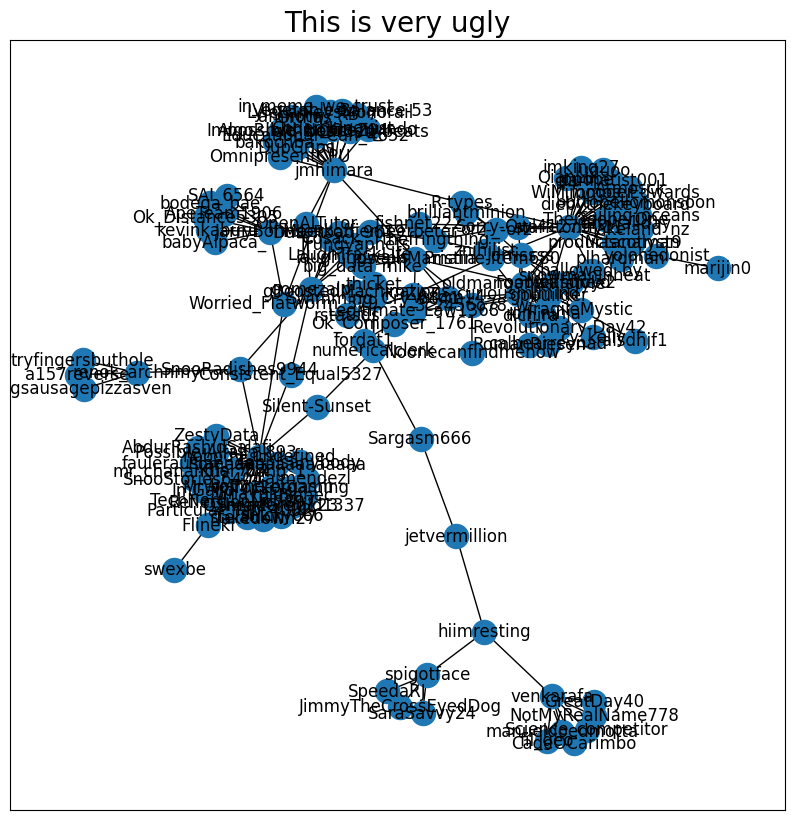

In [61]:
plt.figure(figsize=(10,10))
nx.draw_networkx(GG, pos)
plt.title("This is very ugly", fontsize= 20)

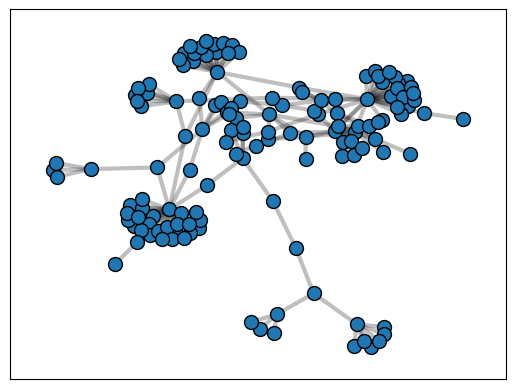

In [62]:
nx.draw_networkx_edges(GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(GG, pos, node_size=100).set_edgecolor('black')

In [63]:
node_attribute_df.to_csv('node_attribute.csv', index=False)
weighted_EL_df.to_csv('edge_commenting.csv', index=False)

# 2. User similarity networks
The goal of this section is to link users with similar activities. We will then visualize this network. The overall steps are:
- Load the dataframe.
- Construct a bipartite network and project on user side.
- Such projection results in a co-affiliation network.
- Visualize network.

In [64]:
ds_user_submission_df = pd.read_csv("./datascience-user-submission.csv")
ds_user_comment_df = pd.read_csv("./datascience-user-comment.csv")

In [ ]:
# Concatenate the DataFrames
ds_user_combined_df = pd.concat([ds_user_submission_df[['author', 'subreddit']],
                                 ds_user_comment_df[['author', 'subreddit']]],
                                 ignore_index=True)

In [ ]:
ds_user_combined_df = ds_user_combined_df[ds_user_combined_df['subreddit'] != 'datascience']
ds_user_combined_df

,author,subreddit
0,venkarafa,rstats
2,venkarafa,statistics
3,venkarafa,statistics
4,venkarafa,statistics
5,gomezalp,programacion
...,...,...
1541,hiimresting,SipsTea
1543,TechNerd10191,gameofthrones
1544,TechNerd10191,gameofthrones
1545,TechNerd10191,MITAdmissions


In [ ]:
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(ds_user_combined_df['author'], bipartite=0)
B.add_nodes_from(ds_user_combined_df['subreddit'], bipartite=1)
# Add edges between users and subreddits
B.add_edges_from(ds_user_combined_df.itertuples(index=False))

# Project the bipartite graph onto the user nodes
users = ds_user_combined_df['author'].unique()
U_G = bipartite.weighted_projected_graph(B, users)

In [ ]:
# Return the largest component
Gcc = sorted(nx.connected_components(U_G), key=len, reverse=True)
U_GG = U_G.subgraph(Gcc[0])

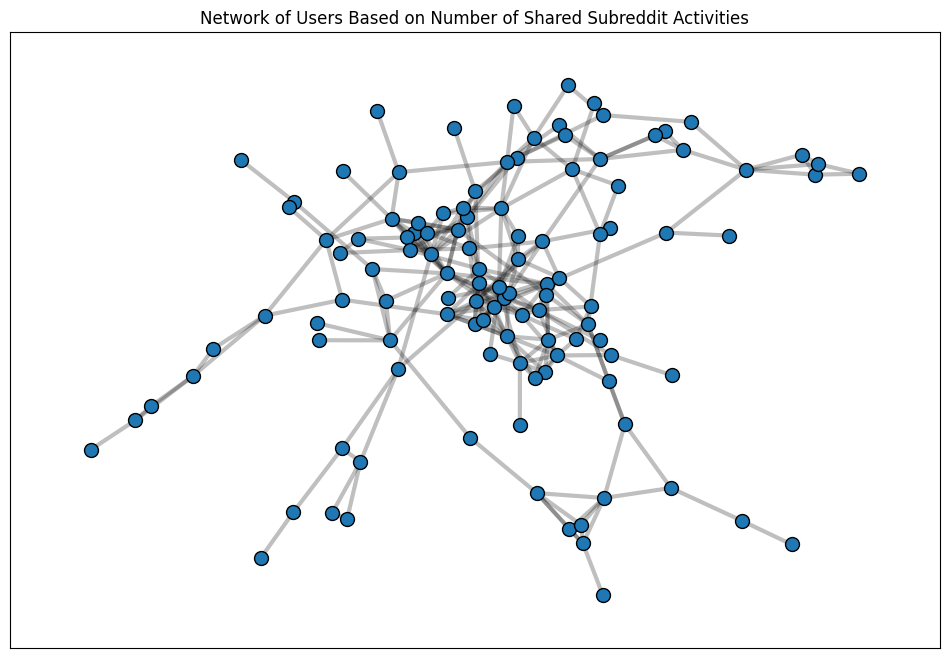

In [ ]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(U_GG, weight = 'weight')  # Positioning of nodes
edges = U_GG.edges(data=True)
nx.draw_networkx_edges(U_GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(U_GG, pos, node_size=100).set_edgecolor('black')

# nx.draw_networkx_edge_labels(U_GG, pos, edge_labels={(u, v): str(d["weight"]) for u, v, d in U_GG.edges(data=True)}, font_size=10)
plt.title("Network of Users Based on Number of Shared Subreddit Activities")
plt.show()

In [ ]:
# Create a list to store the edges and their weights
edge_list = []
for u, v, data in U_G.edges(data=True):
    edge_list.append([u, v, data['weight']])

# Create a Pandas DataFrame from the edge list
user_graph_edgelist_df = pd.DataFrame(edge_list, columns=['Source', 'Target', 'Weight'])
user_graph_edgelist_df


,Source,Target,Weight
0,venkarafa,DubGrips,1
1,venkarafa,jgrowallday,1
2,venkarafa,ImGallo,1
3,venkarafa,Sorry-Owl4127,1
4,renok_archnmy,K9ZAZ,1
...,...,...,...
251,kevinkaburu,hiimresting,1
252,Flineki,Dull_Road_9619,1
253,hiimresting,bovine-orgasm,1
254,TechNerd10191,hallowed_by,1


In [ ]:
user_graph_edgelist_df.to_csv('edge_user_similarity.csv', index=False)

# 3. Subreddit networks

The goal of this subsection is project the bipartite network into subreddit network. We will then visualize this network.

In [ ]:
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(ds_user_combined_df['subreddit'], bipartite=0)
B.add_nodes_from(ds_user_combined_df['author'], bipartite=1)
# Add edges between users and subreddits
B.add_edges_from(ds_user_combined_df.itertuples(index=False))

In [ ]:
# Project the bipartite graph onto the user nodes
subs = ds_user_combined_df['subreddit'].unique()
S_G = bipartite.weighted_projected_graph(B, subs)

In [ ]:
# Return the largest component
Gcc = sorted(nx.connected_components(S_G), key=len, reverse=True)
S_GG = S_G.subgraph(Gcc[0])

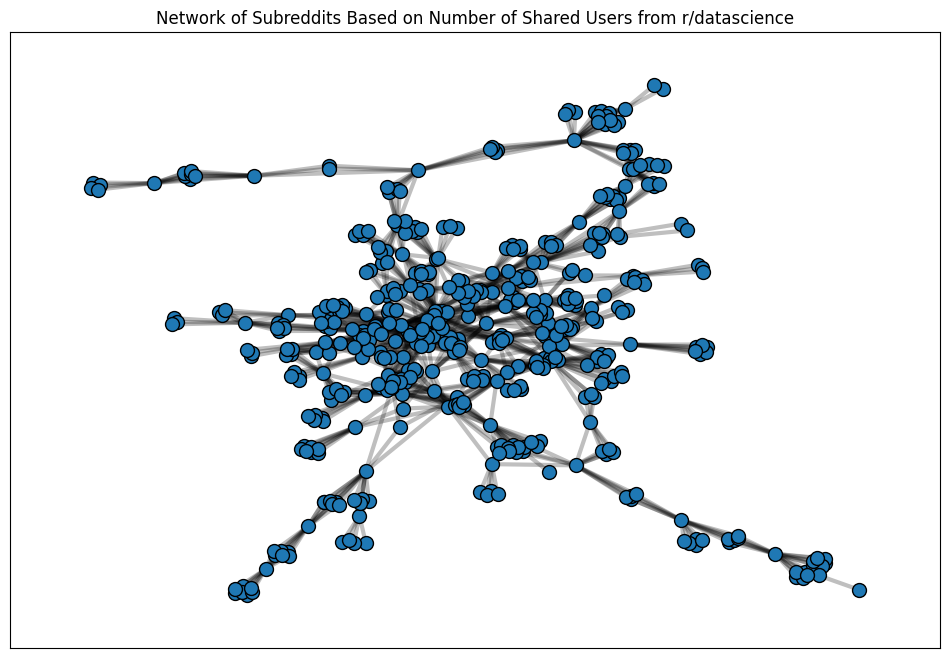

In [ ]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(S_GG, weight = 'weight')  # Positioning of nodes
edges = S_GG.edges(data=True)
nx.draw_networkx_edges(S_GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(S_GG, pos, node_size=100).set_edgecolor('black')

# nx.draw_networkx_edge_labels(S_GG, pos, edge_labels={(u, v): str(d["weight"]) for u, v, d in S_GG.edges(data=True)}, font_size=10)
plt.title("Network of Subreddits Based on Number of Shared Users from r/datascience")
plt.show()

The goal of this section is to merge different dataframes of each subreddit, into a network.
We will then visualize this network.
The overall steps are:
- Load the dataframes.
- Make dictionaries {key: value} that contain each subreddit as keys, and the list of unique users as values.
- Generating an edgelist (weighted by number of shared users), then use it to generate a network object.
- Visualize network

### Read dataframe
We will use six files, each of the files has submission(=post) data of each subreddit dedicated to one programming language.

In [ ]:
%cd '/content/drive/MyDrive/Tutorial_2'

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Correct the file paths based on where you uploaded files
files = {
    'DS': "./datascience-new-submission-for-subreddit-network.csv",
    'ML': "./MachineLearning-new-submission-for-subreddit-network.csv",
    'Data': "./datasets-new-submission-for-subreddit-network.csv",
    'Viz': "./dataisbeautiful-new-submission-for-subreddit-network.csv",
    'Py': "./learnpython-new-submission-for-subreddit-network.csv",
}

/content/drive/MyDrive/Tutorial_2


From the files, we can make a dictionary that contains keys as each subreddits, and values as unique users of each subreddits.

In [ ]:
# Extract unique authors from each file
unique_authors = {file_name: pd.read_csv(file_path)['author'].unique().tolist() for file_name, file_path in files.items()}
unique_authors['DS'][:10]

['renok_archnmy',
 'JarryBohnson',
 'jmhimara',
 'nobody_undefined',
 'gomezalp',
 'Waste_Necessary654',
 'starktonny11',
 'venkarafa',
 'ArticleLegal5612',
 'Gold-Artichoke-9288']

In [ ]:
# Find the intersection of unique authors in 'R' and 'Python'
intersection = set(unique_authors['DS']).intersection(set(unique_authors['ML']))

# Print the intersection
print(intersection)


{'yourmamaman', 'Starktony11', 'AutoModerator'}


After we make that dictionary, we make multiple pairwise comparisons, and count the number of shared users to make an edgelist. For example, if a user A posted on both r/Python and r/rprogramming, we add 1 to the weight of the link between Python and R.

In [ ]:
# Recreate the edge list dataframe
edge_list_data = []

for file_1 in unique_authors.keys():
    for file_2 in unique_authors.keys():
        if file_1 != file_2:
            # Calculate intersection of authors
            common_authors = set(unique_authors[file_1]).intersection(set(unique_authors[file_2]))
            if common_authors:
                edge_list_data.append([file_1, file_2, len(common_authors)])



In [ ]:
# Convert the edge list data to a dataframe
edge_list_df = pd.DataFrame(edge_list_data, columns=['Source', 'Target', 'Weight'])
edge_list_df

,Source,Target,Weight
0,DS,ML,3
1,DS,Viz,1
2,ML,DS,3
3,ML,Data,1
4,Data,ML,1
5,Data,Viz,1
6,Viz,DS,1
7,Viz,Data,1


Let's visualize it in a simple way.

In [ ]:
G = nx.from_pandas_edgelist(edge_list_df, 'Source', 'Target', edge_attr='Weight', create_using=nx.Graph())

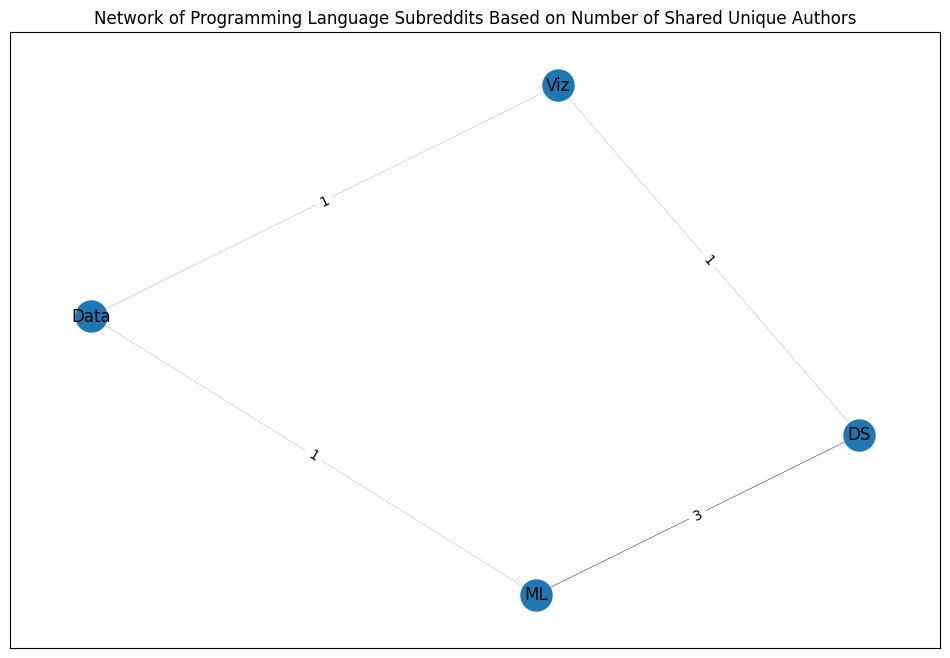

In [ ]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, weight = 'Weight')  # Positioning of nodes
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[edata['Weight'] * 0.1 for _, _, edata in edges])
nx.draw_networkx_labels(G, pos, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): str(d["Weight"]) for u, v, d in G.edges(data=True)}, font_size=10)
plt.title("Network of Programming Language Subreddits Based on Number of Shared Unique Authors")
plt.show()

Of course, the result is same even if you use the bipartite network projection.

In [ ]:
# Create an empty list to store the data for the new DataFrame
new_df_data = []

# Iterate through the files dictionary
for name, file_path in files.items():
  # For each subreddit, create a list of dictionaries with 'subreddit' and 'author' columns
  for author in unique_authors[name]:
    new_df_data.append({'subreddit': name, 'author': author})

# Create the new DataFrame from the list of dictionaries
new_df = pd.DataFrame(new_df_data)
print(new_df)


    subreddit              author
0          DS       renok_archnmy
1          DS        JarryBohnson
2          DS            jmhimara
3          DS    nobody_undefined
4          DS            gomezalp
..        ...                 ...
452        Py    Public-Count6412
453        Py       BigPoppaG4000
454        Py   Important_Bad5861
455        Py    BarryTownCouncil
456        Py  Character_Slip2901

[457 rows x 2 columns]


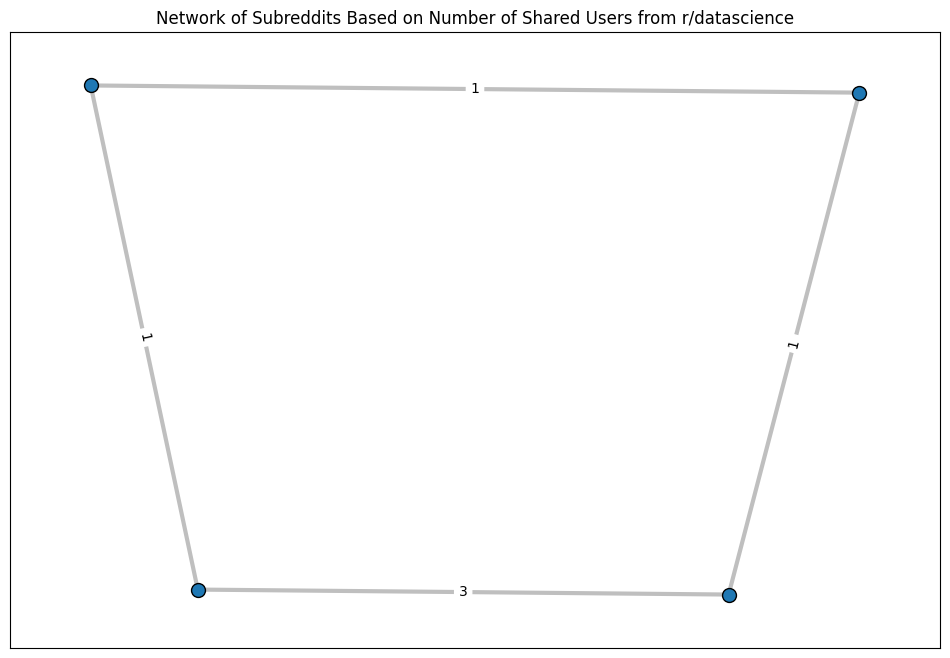

In [ ]:
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(new_df['subreddit'], bipartite=0)
B.add_nodes_from(new_df['author'], bipartite=1)
# Add edges between users and subreddits
B.add_edges_from(new_df.itertuples(index=False))

# Project the bipartite graph onto the user nodes
subs = new_df['subreddit'].unique()
S_G = bipartite.weighted_projected_graph(B, subs)

# Return the largest component
Gcc = sorted(nx.connected_components(S_G), key=len, reverse=True)
S_GG = S_G.subgraph(Gcc[0])

# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(S_GG, weight = 'weight')  # Positioning of nodes
edges = S_GG.edges(data=True)
nx.draw_networkx_edges(S_GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(S_GG, pos, node_size=100).set_edgecolor('black')

nx.draw_networkx_edge_labels(S_GG, pos, edge_labels={(u, v): str(d["weight"]) for u, v, d in S_GG.edges(data=True)}, font_size=10)
plt.title("Network of Subreddits Based on Number of Shared Users from r/datascience")
plt.show()

# On your own
3.1. With csv files that you scraped with Reddit Scraper, make 3 types of networks (user interaction, user similarity, subreddit similarity) and visualize them.  
3.2. Visualize user interaction data with Gephi.